# Выполнение АА-теста необходимо нам для проверки корректности работы системы сплитирования, которая была применена для нашего набора данных. Это крайне важный этап для последующего проведения AB-теста. Первым этапом для выполнения задания является импортирование необходимых для анализа питон-бибилиотек;

In [138]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandahouse
import scipy.stats as stats
%matplotlib inline

# Следующим этапом послужит создание датафрейма из селект запроса по нужным экспериметнальным группам и датам, по которым нам необходимо провести АА-тест, используя применимые для этого билиотеки;

In [139]:
connection_0 = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20221220',
                      'user':'student', 
                      'password':'dpo_python_2020'
}

query = """
SELECT exp_group, user_id, SUM(action = 'like') AS likes, SUM(action = 'view') AS views, likes/ views AS CTR
FROM {db}.feed_actions
WHERE (toDate(time) BETWEEN '2022-11-25' AND '2022-12-01' ) AND exp_group IN (2, 3)
GROUP BY exp_group, user_id
"""
df = pandahouse.read_clickhouse(query, connection = connection_0)
df

,exp_group,user_id,likes,views,CTR
0,3,115383,11,36,0.305556
1,3,123580,15,92,0.163043
2,2,131473,26,148,0.175676
3,2,23985,12,66,0.181818
4,2,24523,17,120,0.141667
...,...,...,...,...,...
17044,3,122008,4,31,0.129032
17045,2,25383,16,57,0.280702
17046,3,122190,25,74,0.337838
17047,2,108927,8,33,0.242424


# В полученном датафрейме можно посмотреть количество пользователей по экспериментальным группа;

In [140]:
df.groupby('exp_group')['user_id'].count()

exp_group
2    8480
3    8569
Name: user_id, dtype: int64

# Как видим, количество пользователей в группа примерно одинаковое, хотя и во второй группе их больше на 89, чем в третьей. Далее построим гистограмму распределения CTR по экспериментальным группам;


<AxesSubplot:xlabel='CTR', ylabel='Count'>

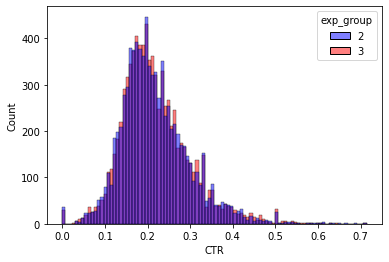

In [141]:
sns.histplot(data = df, x = 'CTR', hue = 'exp_group', palette = ['b', 'r'])

# Визуально по графику можно сделать вывод, что расределение CTR по экспериментальным группа примерно одинаковое. Далее проведем Т-тест по двум экспериментальным группа, дисперсии нам неизвестны;

In [142]:
a, b = df[df.exp_group == 2].CTR, df[df.exp_group == 3].CTR
stats.ttest_ind(a, b, equal_var = False)

Ttest_indResult(statistic=-0.7393597924958364, pvalue=0.45969873156476293)

# По результатам Т-теста P-уровень значимости составил ~ 0.46, а это значит, что у нас нет оснований отклонить гипотезу о том, что эти группы отличаются. Согласно заданию, нам необходимо провести 10000 АА-тестов, в рамках которых из каждой из экспериментальной групп будет выбрано по 500 случайных пользователей;

In [143]:
z = []
for i in range(10000):
    z1 = a.sample(n = 500, replace = False).to_list()
    z2 = b.sample(n = 500, replace = False).to_list()
    z.append(stats.ttest_ind(z1, z2, equal_var = False)[1])

        
    

# По полученным значениям необходиму построить гистограмму; 

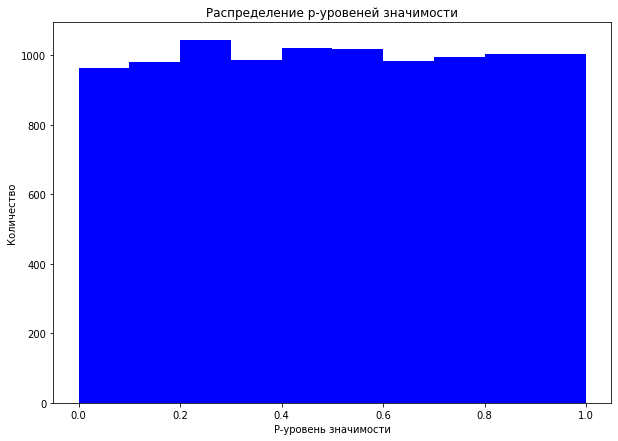

In [144]:
fig, ax = plt.subplots(1, 1, figsize = (10, 7))

ax.hist(z, density = False, facecolor = 'b')

plt.xlabel('P-уровень значимости') 
plt.ylabel('Количество') 
plt.title('Распределение p-уровеней значимости') 

plt.show()

# Далее по полученным данным необходимо посчитать, какое количество % наблюдений имею р-значение меньше или равное 0,05;

In [145]:
counter = 0
for i in range(len(z)):
    if z[i] <= 0.05:
        counter += 1
f = counter/len(z) * 100
if f <= 5:
    print('Вывод по выполнению задания следующий: по результатам проведенных АА-тестов, ' +  str(f) + ' % от всех наблюдений имеют различное значение CTR от общей выборки, что позволяет принять гипотезу о том, что экспериментальные группы 2 и 3 не имеют различий. Можно утверждать, что система сплитирования работает правильно.')
else:
    print('Вывод по выполнению задания следующий: по результатам проведенных АА-тестов, ' +  str(f) + ' % от всех наблюдений имеют различное значение CTR от общей выборки, что позволяет принять гипотезу о том, что экспериментальные группы 2 и 3 имею различия. Можно утверждать, что система сплитирования работает неправильно.')


Вывод по выполнению задания следующий: по результатам проведенных АА-тестов, 4.67 % от всех наблюдений имеют различное значение CTR от общей выборки, что позволяет принять гипотезу о том, что экспериментальные группы 2 и 3 не имеют различий. Можно утверждать, что система сплитирования работает правильно.


# Вывод по проделанному заданию написан выше.
